In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
import statistics

In [1]:
'ggg'+'/'

'ggg/'

In [2]:
INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_main_new'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select "EM_TOTAL_Import_Energy(kWh)", "DeviceID", "time" from ' + TARGET_MEASUREMENT + ' where time > now() - 30d '
data = pd.DataFrame(con_obj.query(query).get_points())
data['time'] = data['time'].astype('datetime64[ns]')
data['time'] = data['time'] + datetime.timedelta(hours=5, minutes=30)

In [3]:
df2 = data.copy()

In [4]:
class half_an_hour_min_energy:  
    
    def difference(self,df2):
        diff = []
        for g,i in df2.groupby(pd.Grouper(freq ='H',key ='time'))['EM_TOTAL_Import_Energy(kWh)']:
            try:
                diff.append([g,i.iloc[-1]-i.iloc[0]])
            except:
                diff.append([g,np.nan])
        x=pd.DataFrame(diff)
        return x        
                
    def output(self, df2):
            y = df2.groupby('DeviceID').apply(self.difference)
            y = y.pivot_table(index = 0,columns ='DeviceID',values = 1).reset_index()
            y.columns.name = None
            y = y.rename(columns = {0: ""})
            y = y.set_index("")
            y = y.fillna(0)
            return y

In [5]:
cat = half_an_hour_min_energy()
df4 = cat.output(df2)
df4.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
,,,,,,,,,,,,
2020-06-22 12:00:00,162.0,0.1,0.0,0.0,0.0,0.0,33.0,39.0,0.0,0.0,0.0,5.8
2020-06-22 13:00:00,896.0,0.5,0.0,0.0,0.0,0.0,184.0,225.0,0.0,0.1,0.0,29.3
2020-06-22 14:00:00,913.0,8.2,0.0,0.0,0.0,0.0,196.0,228.0,0.0,0.0,0.0,38.1
2020-06-22 15:00:00,932.0,17.0,0.0,0.0,0.0,0.0,199.0,244.0,0.0,0.0,0.0,38.4
2020-06-22 16:00:00,947.0,30.7,0.0,0.0,0.0,0.0,209.0,254.0,0.0,0.1,0.0,31.3


In [6]:
date_old = (pd.datetime.now().date() - pd.offsets.Day(30))
date_now = pd.datetime.now().date() - pd.offsets.Day(0)
Time_range = pd.DataFrame(pd.date_range(start = date_old, end = date_now, freq = 'H'))
Time_range = Time_range.rename(columns={0: "time"})
Time_range.set_index("time", inplace=True)
df = df4.merge(Time_range, how="outer", right_index=True, left_index=True)
df = df.interpolate(method='time')
df = df.fillna(0)
df.index.freq = 'H'

In [7]:
print(df.index.min())
print(df.index.max())

2020-06-22 00:00:00
2020-07-22 11:00:00


In [8]:
EM4 = df[['EM4']]

In [17]:
print(EM4.index.min())
print(EM4.index.max())

2020-06-22 00:00:00
2020-07-22 11:00:00


360


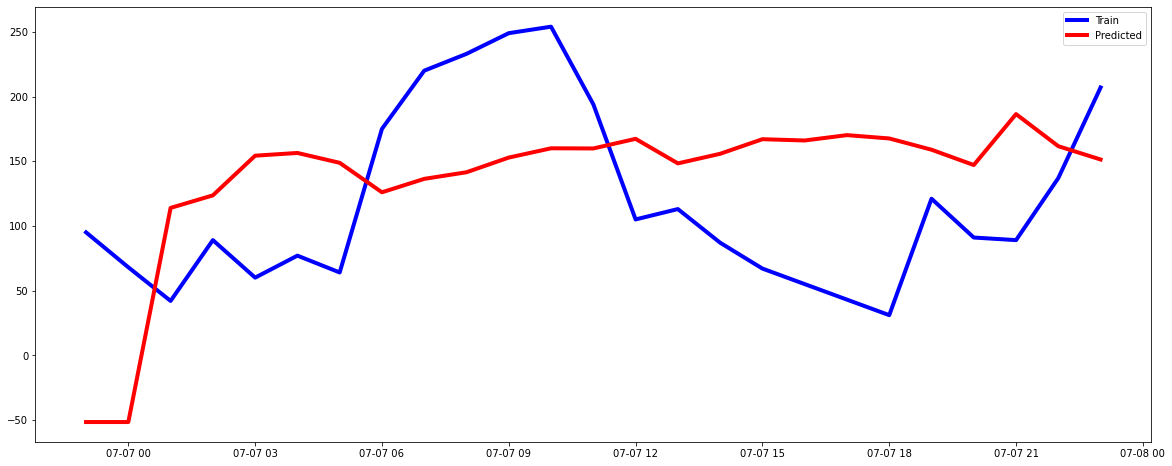

86.34248352907917


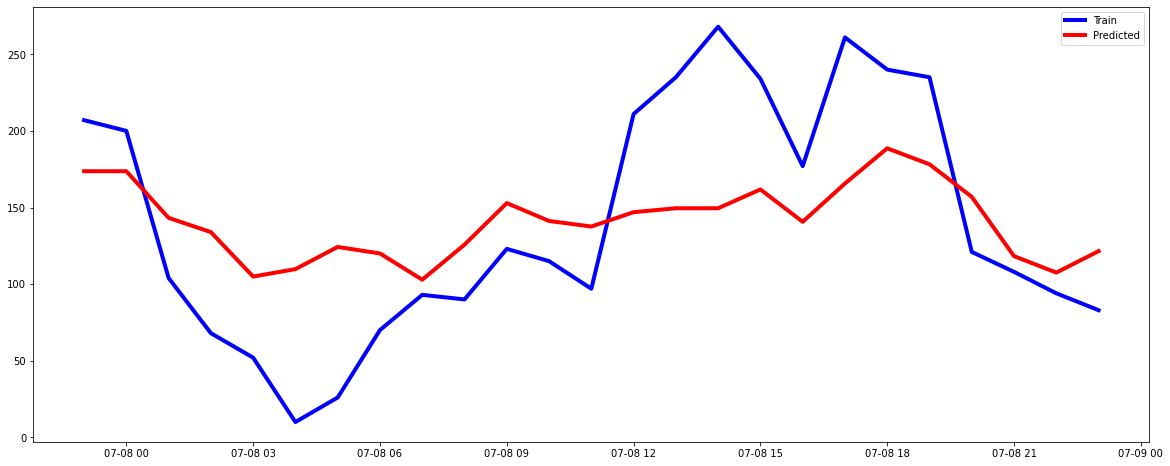

59.062675144394696


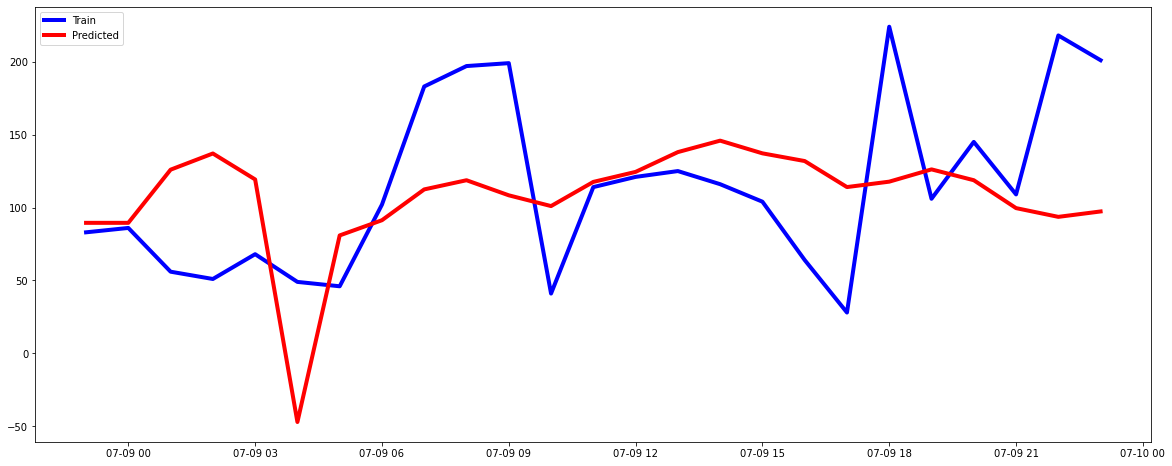

63.67495270270429


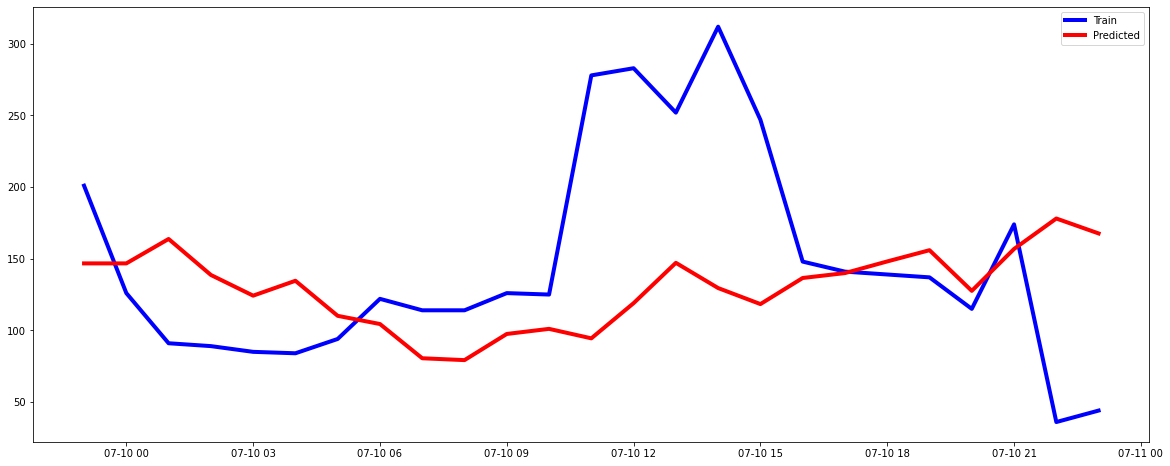

84.25581718671059


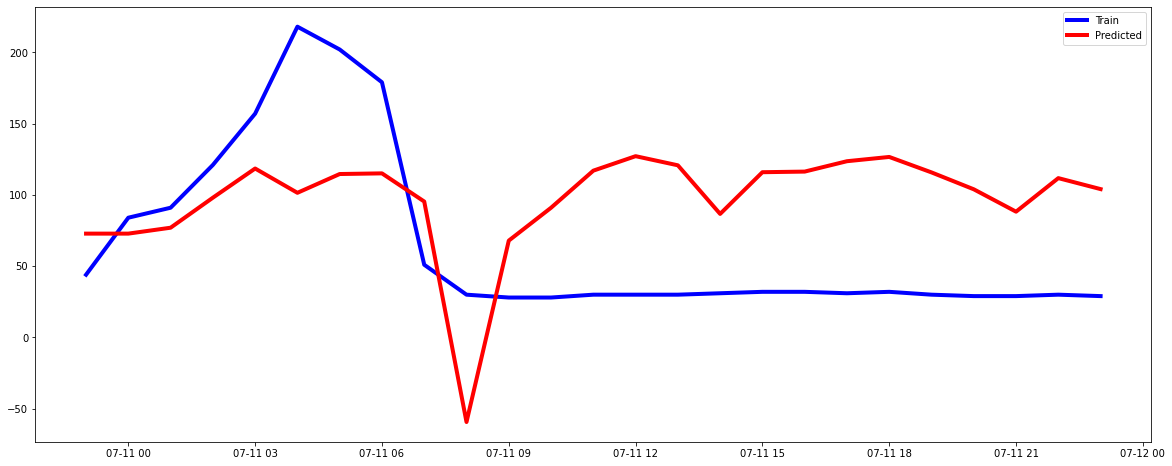

72.88321942837982


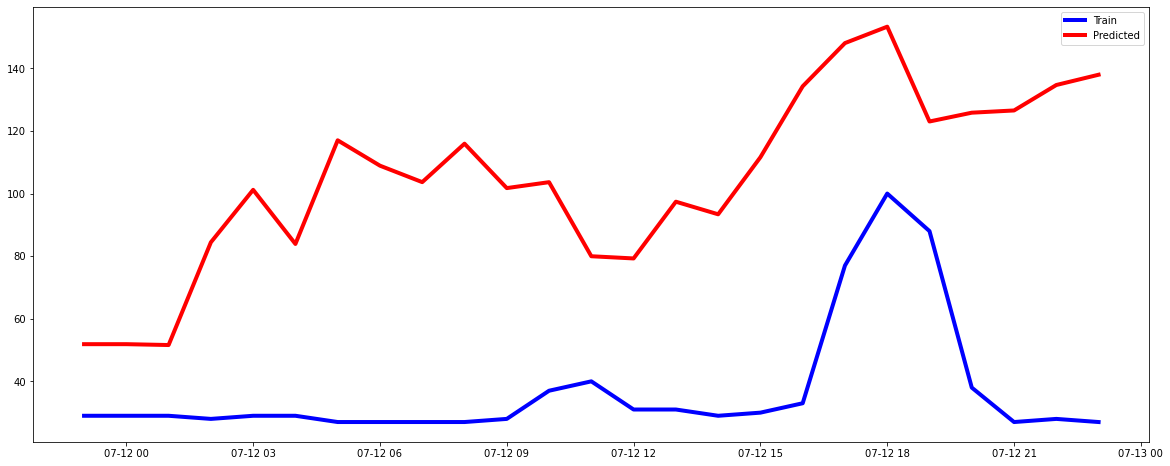

72.46690602994404


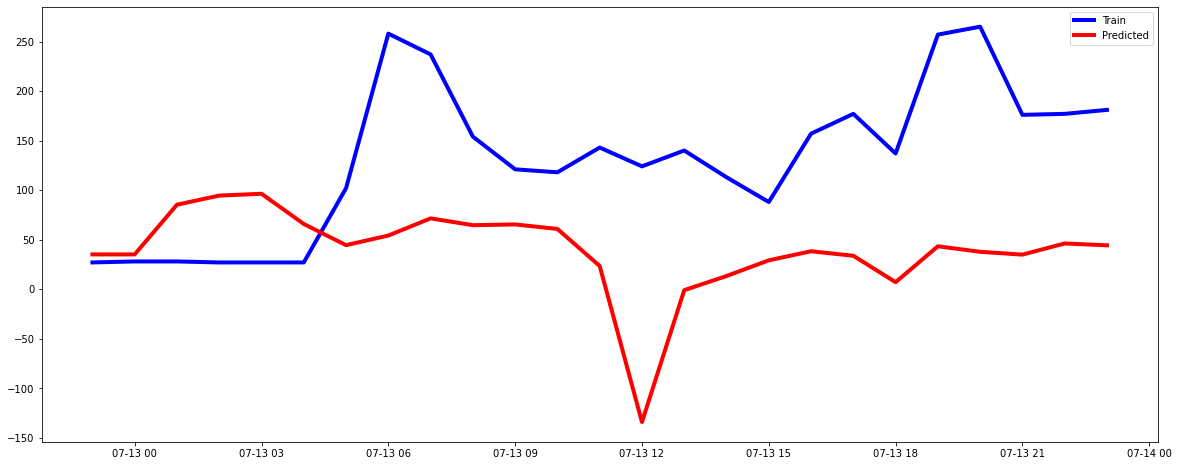

129.55880509534325


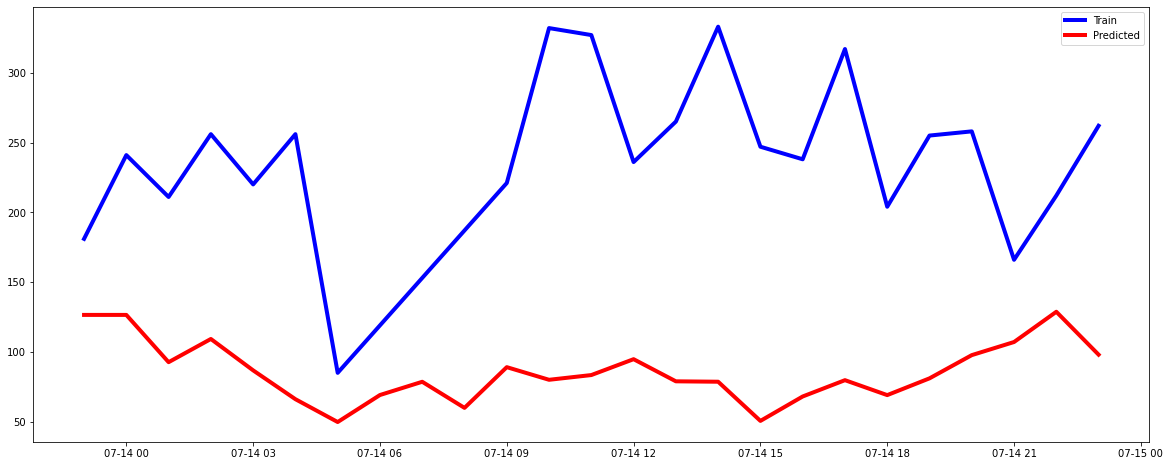

158.18558400513024


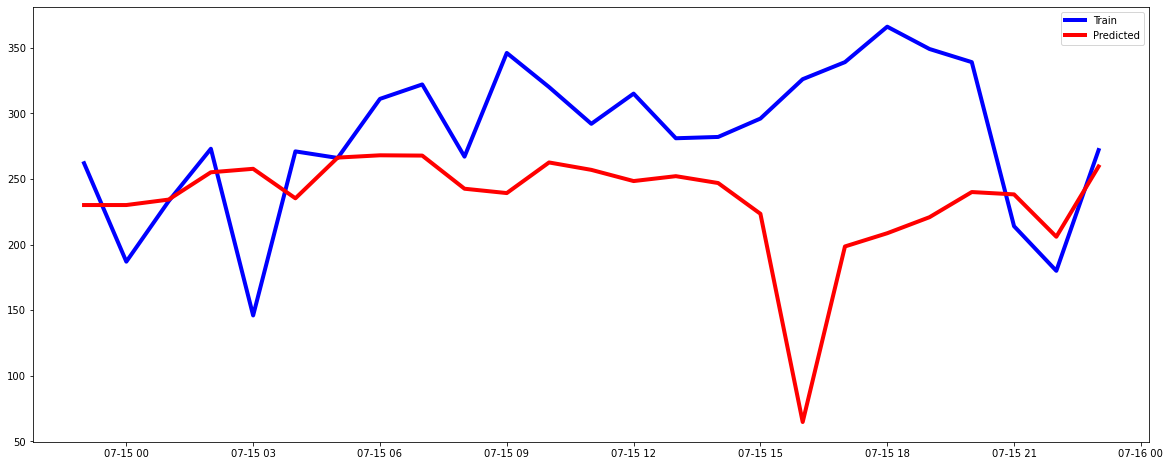

87.26221859396367


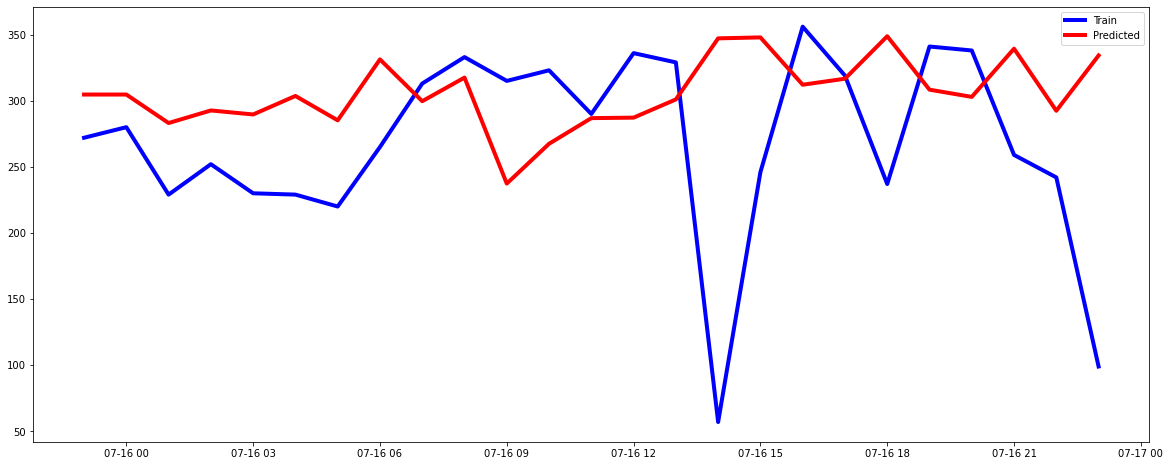

92.16692494774266


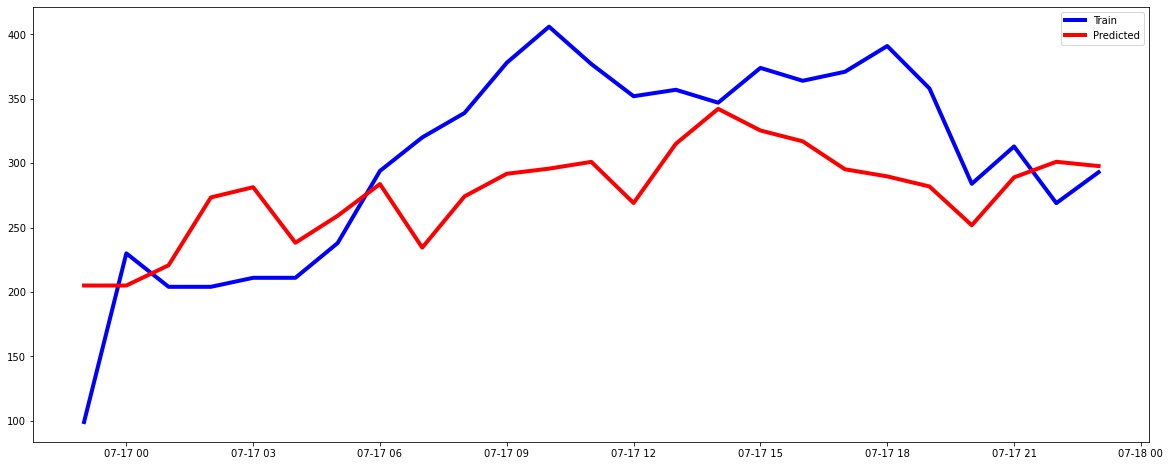

62.52809355112422


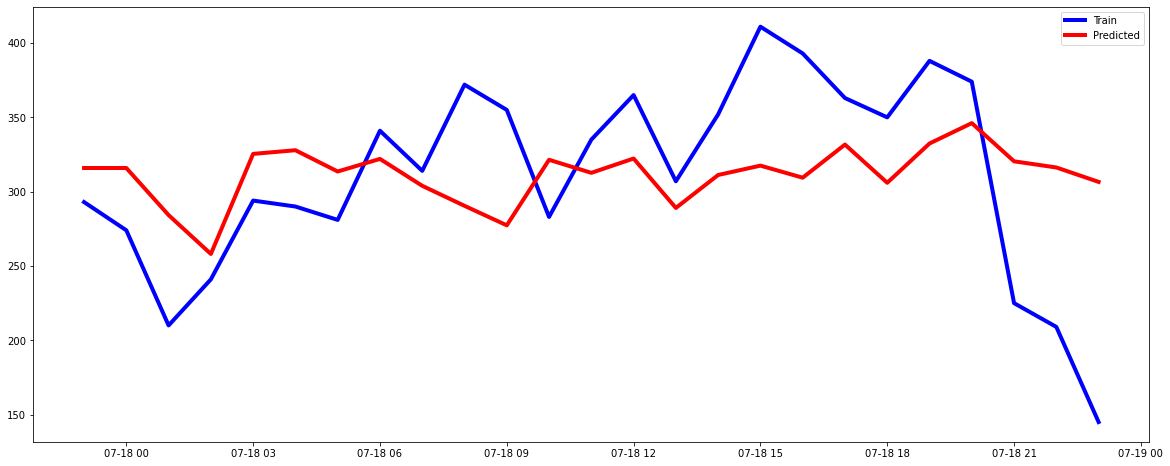

63.15781884508475


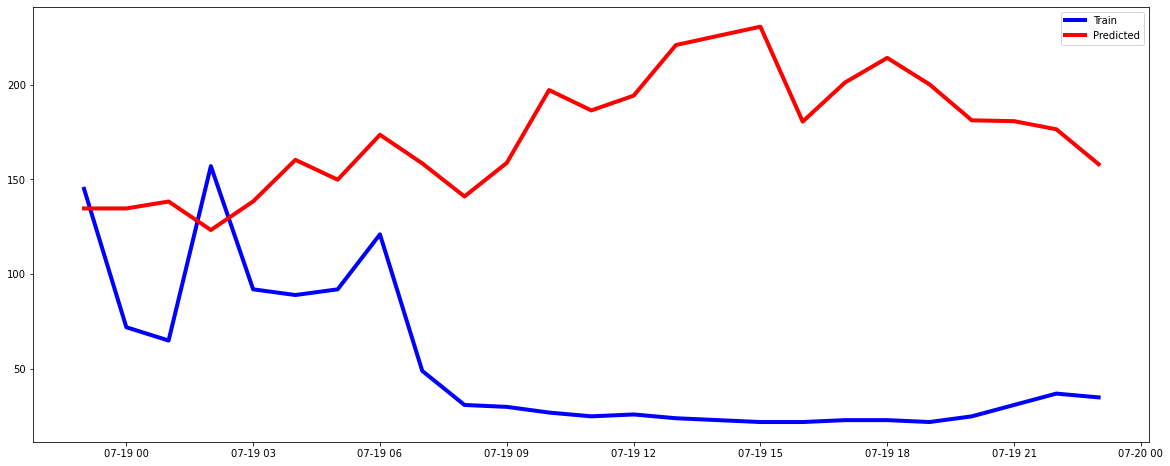

138.21699877352358


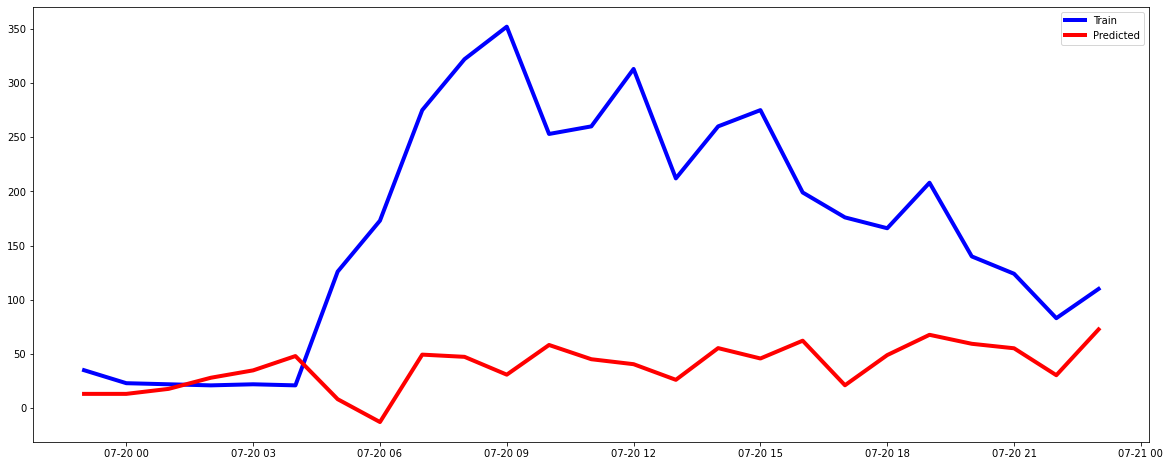

162.25842733680753


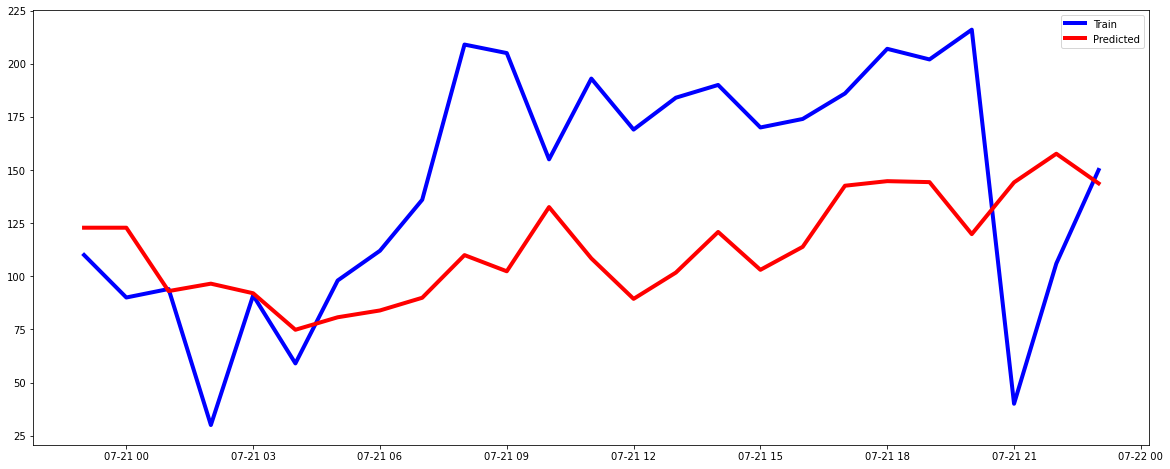

61.659480884350984


In [45]:
RMSE = []
m = 0
days = 24*15
print(days)
test_size = 24
for i in range((days+test_size),len(EM4),test_size):
    EM4_new = EM4.iloc[m:i]
    train = EM4_new[0 : -test_size]
    test = EM4_new[-(test_size + 1):]
    yhat = test.copy()
#     print(yhat)
    m = i - days
    import warnings
    warnings.filterwarnings('ignore')
    x = 52
    order = [1,1,1]
    seasonal_order = [0,1,1,x]
    a = len(test)
    model = SARIMAX(train, order = order, seasonal_order = seasonal_order, typ = 'levels').fit(disp = False, transparams = False, trend = 'c', solver = 'lbfgs')
    yhat['predictions'] = model.forecast(a)
    yhat['predictions'] = yhat['predictions'].fillna(method = "bfill")
    yhat['rms'] = sqrt(mean_squared_error(yhat['EM4'], yhat['predictions']))
    plt.figure(figsize=(20,8))
    plt.plot(test['EM4'], label='Train', lw = 4, color = 'blue')
    plt.plot(yhat['predictions'], label='Predicted', lw = 4, color = 'red')
    plt.legend(loc='best')
    plt.show()
    r = yhat['rms'].mean()
    RMSE.append(r)
    print(yhat['rms'].mean())

In [46]:
print(statistics.mean(RMSE))

92.91202707028556


In [47]:
pd.DataFrame(RMSE).describe()

,0
count,15.000000
mean,92.912027
std,36.075923
min,59.062675
25%,63.416386
50%,84.255817
75%,110.862865
max,162.258427
